In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import warnings
from IPython.display import display, HTML, Javascript, Image
display(HTML("<style>.container { width:60% !important; }</style>"))
pd.options.display.max_columns = None
warnings.filterwarnings('ignore') 
%autosave 60

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import random
random.seed(42)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

Autosaving every 60 seconds


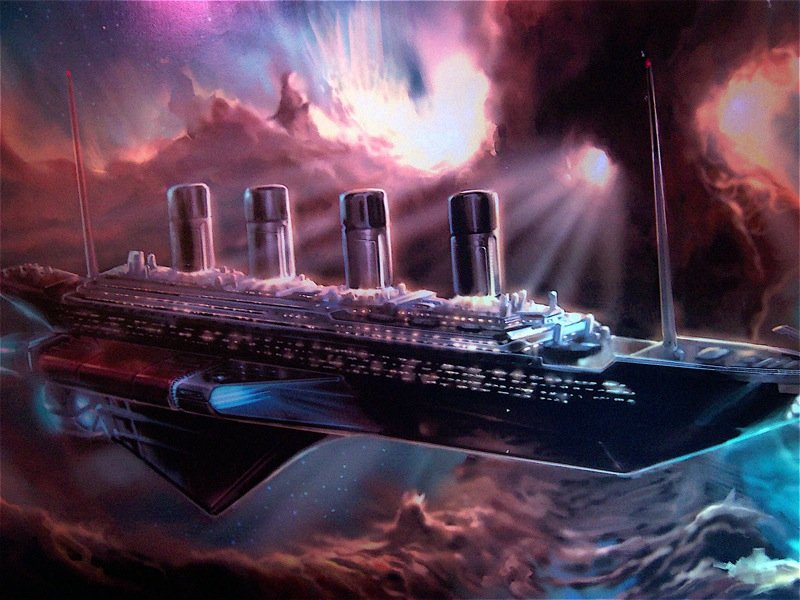

In [3]:
Image(filename="fon_1.jpg", width=1500, height=1200)

In [4]:
train = pd.read_csv(r"C:\Users\123123\Downloads\Kaggle\Spaceship Titanic\train.csv")
test = pd.read_csv(r"C:\Users\123123\Downloads\Kaggle\Spaceship Titanic\test.csv")
sample_submission = pd.read_csv(r"C:\Users\123123\Downloads\Kaggle\Spaceship Titanic\sample_submission.csv")

## Data description
- **PassengerId** - Уникальный идентификатор каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg указывает на группу, с которой пассажир путешествует, а pp - их номер внутри группы. Люди в группе часто являются членами семьи, но не всегда.
- **HomePlanet** - Планета, с которой пассажир отправился в путешествие, обычно его планета постоянного проживания.
- **CryoSleep** - Указывает, выбрал ли пассажир быть помещенным в приостановленное анимационное состояние на время путешествия. Пассажиры в криосне находятся в своих каютах.
- **Cabin** - Номер каюты, в которой остановился пассажир. Принимает форму deck/num/side, где side может быть P для Port (левого борта) или S для Starboard (правого борта).
- **Destination** - Планета, на которую пассажир собирается высаживаться.
- **Age** - Возраст пассажира.
- **VIP** - Платил ли пассажир за особенное обслуживание VIP во время путешествия.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Сумма, которую пассажир потратил на каждое из множества роскошных удобств космического корабля "Титаник".
- **Name** - Имя и фамилия пассажира.
- **Transported** - Был ли пассажир транспортирован в другое измерение. Это целевая переменная, столбец, который вы пытаетесь предсказать.

In [5]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Preprocessing and generation of new features

In [7]:
# функция преобработки и создания фичей
def preprocessing(data):
    
    # разделяем стобец на 3 части deck/num/side
    data[['deck', 'num', 'side']] = data['Cabin'].str.split('/', expand=True)
    data['deck'].fillna(data['deck'].mode(), inplace=True)
    data['num'].fillna(data['num'].median(), inplace=True)
    data['side'].fillna(data['side'].mode(), inplace=True)
    data.drop('Cabin', axis=1, inplace=True)

    # разделяем PassengerId на группу и номер
    data['GroupID'] = data['PassengerId'].str.split('_').str[0]
    data['GroupNumber'] = data['PassengerId'].str.split('_').str[1]
    data['GroupID'] = data['GroupID'].astype(int)
    data['GroupNumber'] = data['GroupNumber'].astype(int)
    data.drop('PassengerId', axis=1, inplace=True)

    # раздеяем Name на имя и фамилию
    data[['FirstName', 'LastName']] = data['Name'].str.split(' ', n=1, expand=True)
    data.drop('Name', axis=1, inplace=True)

    # переводим булевы значения в 0 и 1
    data['VIP'] = data['VIP'] * 1
    
    # проверяем наличие столбца 'Transported' перед его преобразованием
    if 'Transported' in data.columns:
        data['Transported'] = data['Transported'] * 1
        
    data['CryoSleep'] = data['CryoSleep'] * 1
    
    # фичи возрастной группы 
    data['Underage'] = data['Age'] <= 16
    data['Age_group'] = (pd.cut(data['Age'],
            bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
            labels=[0, 1, 2, 3, 2, 2, 1, 0],
            right=False, ordered=False))
    data['Age_group'] = data['Age_group'].fillna(0)
    
    # фичи оплаты    
    data["pay1"] = data['RoomService'] + data['Spa'] + data['VRDeck']
    data['pay2'] = data['FoodCourt'] + data['ShoppingMall']
    data["pay"] = data["RoomService"] + data["FoodCourt"] + data["ShoppingMall"] + data["Spa"] + data["VRDeck"]
    
    return data

In [8]:
# функция заполнения пропусков
def preprocess_data(data):
    data['Age'].fillna(data['Age'].median(), inplace=True)   
    data['CryoSleep'].fillna(data['CryoSleep'].mode().iloc[0], inplace=True)
    data['HomePlanet'].fillna(data['HomePlanet'].mode().iloc[0], inplace=True)
    data['Destination'].fillna(data['Destination'].mode().iloc[0], inplace=True)
    data['VIP'].fillna(data['VIP'].mode().iloc[0], inplace=True)
    data['deck'].fillna(data['deck'].mode().iloc[0], inplace=True)
    data['side'].fillna(data['side'].mode().iloc[0], inplace=True)
    data['FirstName'].fillna('Unknown', inplace=True)
    data['LastName'].fillna('Unknown', inplace=True)
    data['RoomService'].fillna(data['RoomService'].median(), inplace=True)
    data['FoodCourt'].fillna(data['FoodCourt'].median(), inplace=True)
    data['ShoppingMall'].fillna(data['ShoppingMall'].median(), inplace=True)
    data['Spa'].fillna(data['Spa'].median(), inplace=True)
    data['VRDeck'].fillna(data['VRDeck'].median(), inplace=True)
    data["pay"].fillna(data['pay'].median(), inplace=True)
    data['pay1'].fillna(data['pay1'].median(), inplace=True)
    data['pay2'].fillna(data['pay2'].median(), inplace=True)
    
    return data

In [9]:
def cabin_num(data):
    data['num'] = pd.to_numeric(data['num'], errors='coerce')
    data['CabinRegion1']=(data['num']<300).astype(int)   
    data['CabinRegion2']=((data['num']>=300) & (data['num']<600)).astype(int)
    data['CabinRegion3']=((data['num']>=600) & (data['num']<900)).astype(int)
    data['CabinRegion4']=((data['num']>=900) & (data['num']<1170)).astype(int)
    data['CabinRegion5']=((data['num']>=1170) & (data['num']<1500)).astype(int)
    data['CabinRegion6']=((data['num']>=1500) & (data['num']<1800)).astype(int)
    data['CabinRegion7']=(data['num']>=1800).astype(int)

    data['CabinRegion1']=(data['num']<300).astype(int)   
    data['CabinRegion2']=((data['num']>=300) & (data['num']<600)).astype(int)
    data['CabinRegion3']=((data['num']>=600) & (data['num']<900)).astype(int)
    data['CabinRegion4']=((data['num']>=900) & (data['num']<1170)).astype(int)
    data['CabinRegion5']=((data['num']>=1170) & (data['num']<1500)).astype(int)
    data['CabinRegion6']=((data['num']>=1500) & (data['num']<1800)).astype(int)
    data['CabinRegion7']=(data['num']>=1800).astype(int)
    
    return data

In [10]:
train = preprocessing(train)
train = preprocess_data(train)
train = cabin_num(train)

## Visualization of updated data

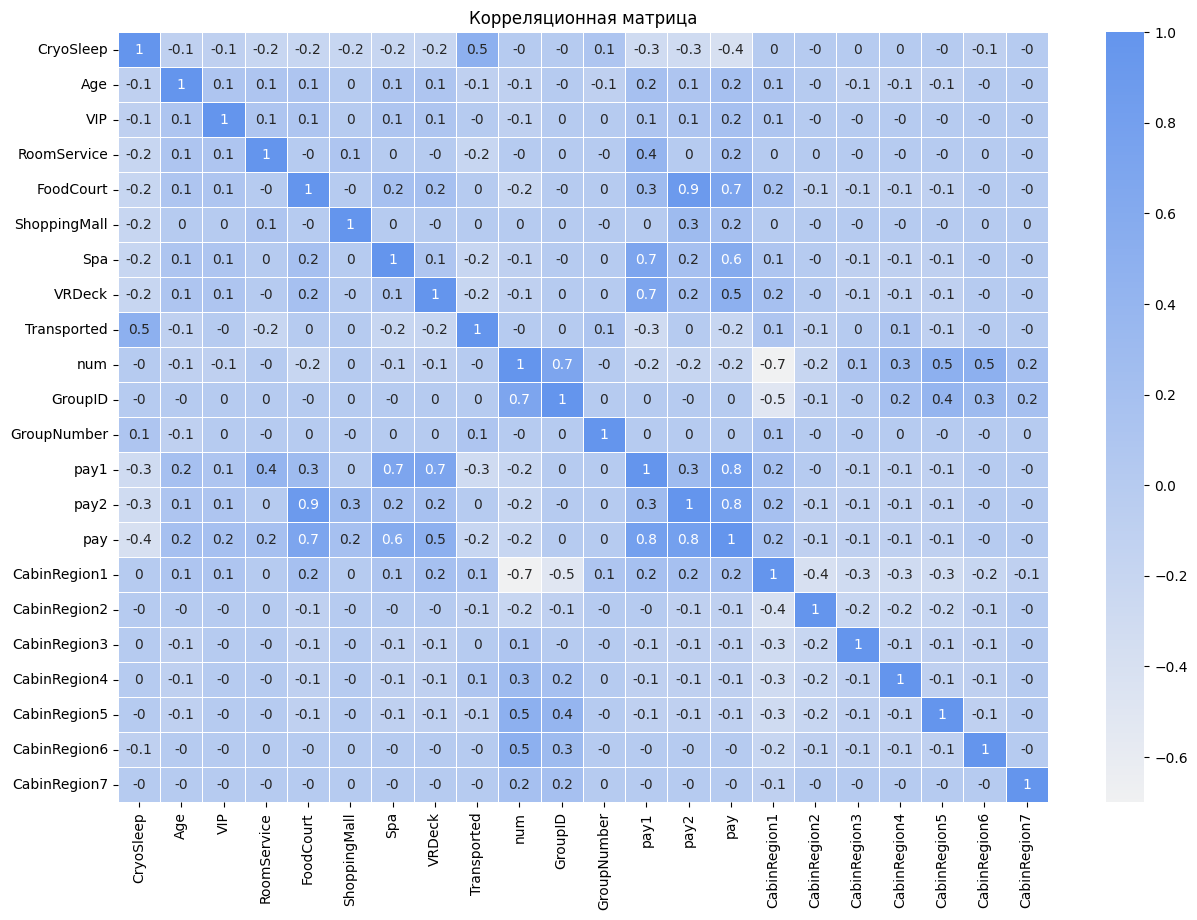

In [11]:
# корреляционная матрица
numeric_columns = train.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr().round(1)
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.light_palette("cornflowerblue", as_cmap=True), linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

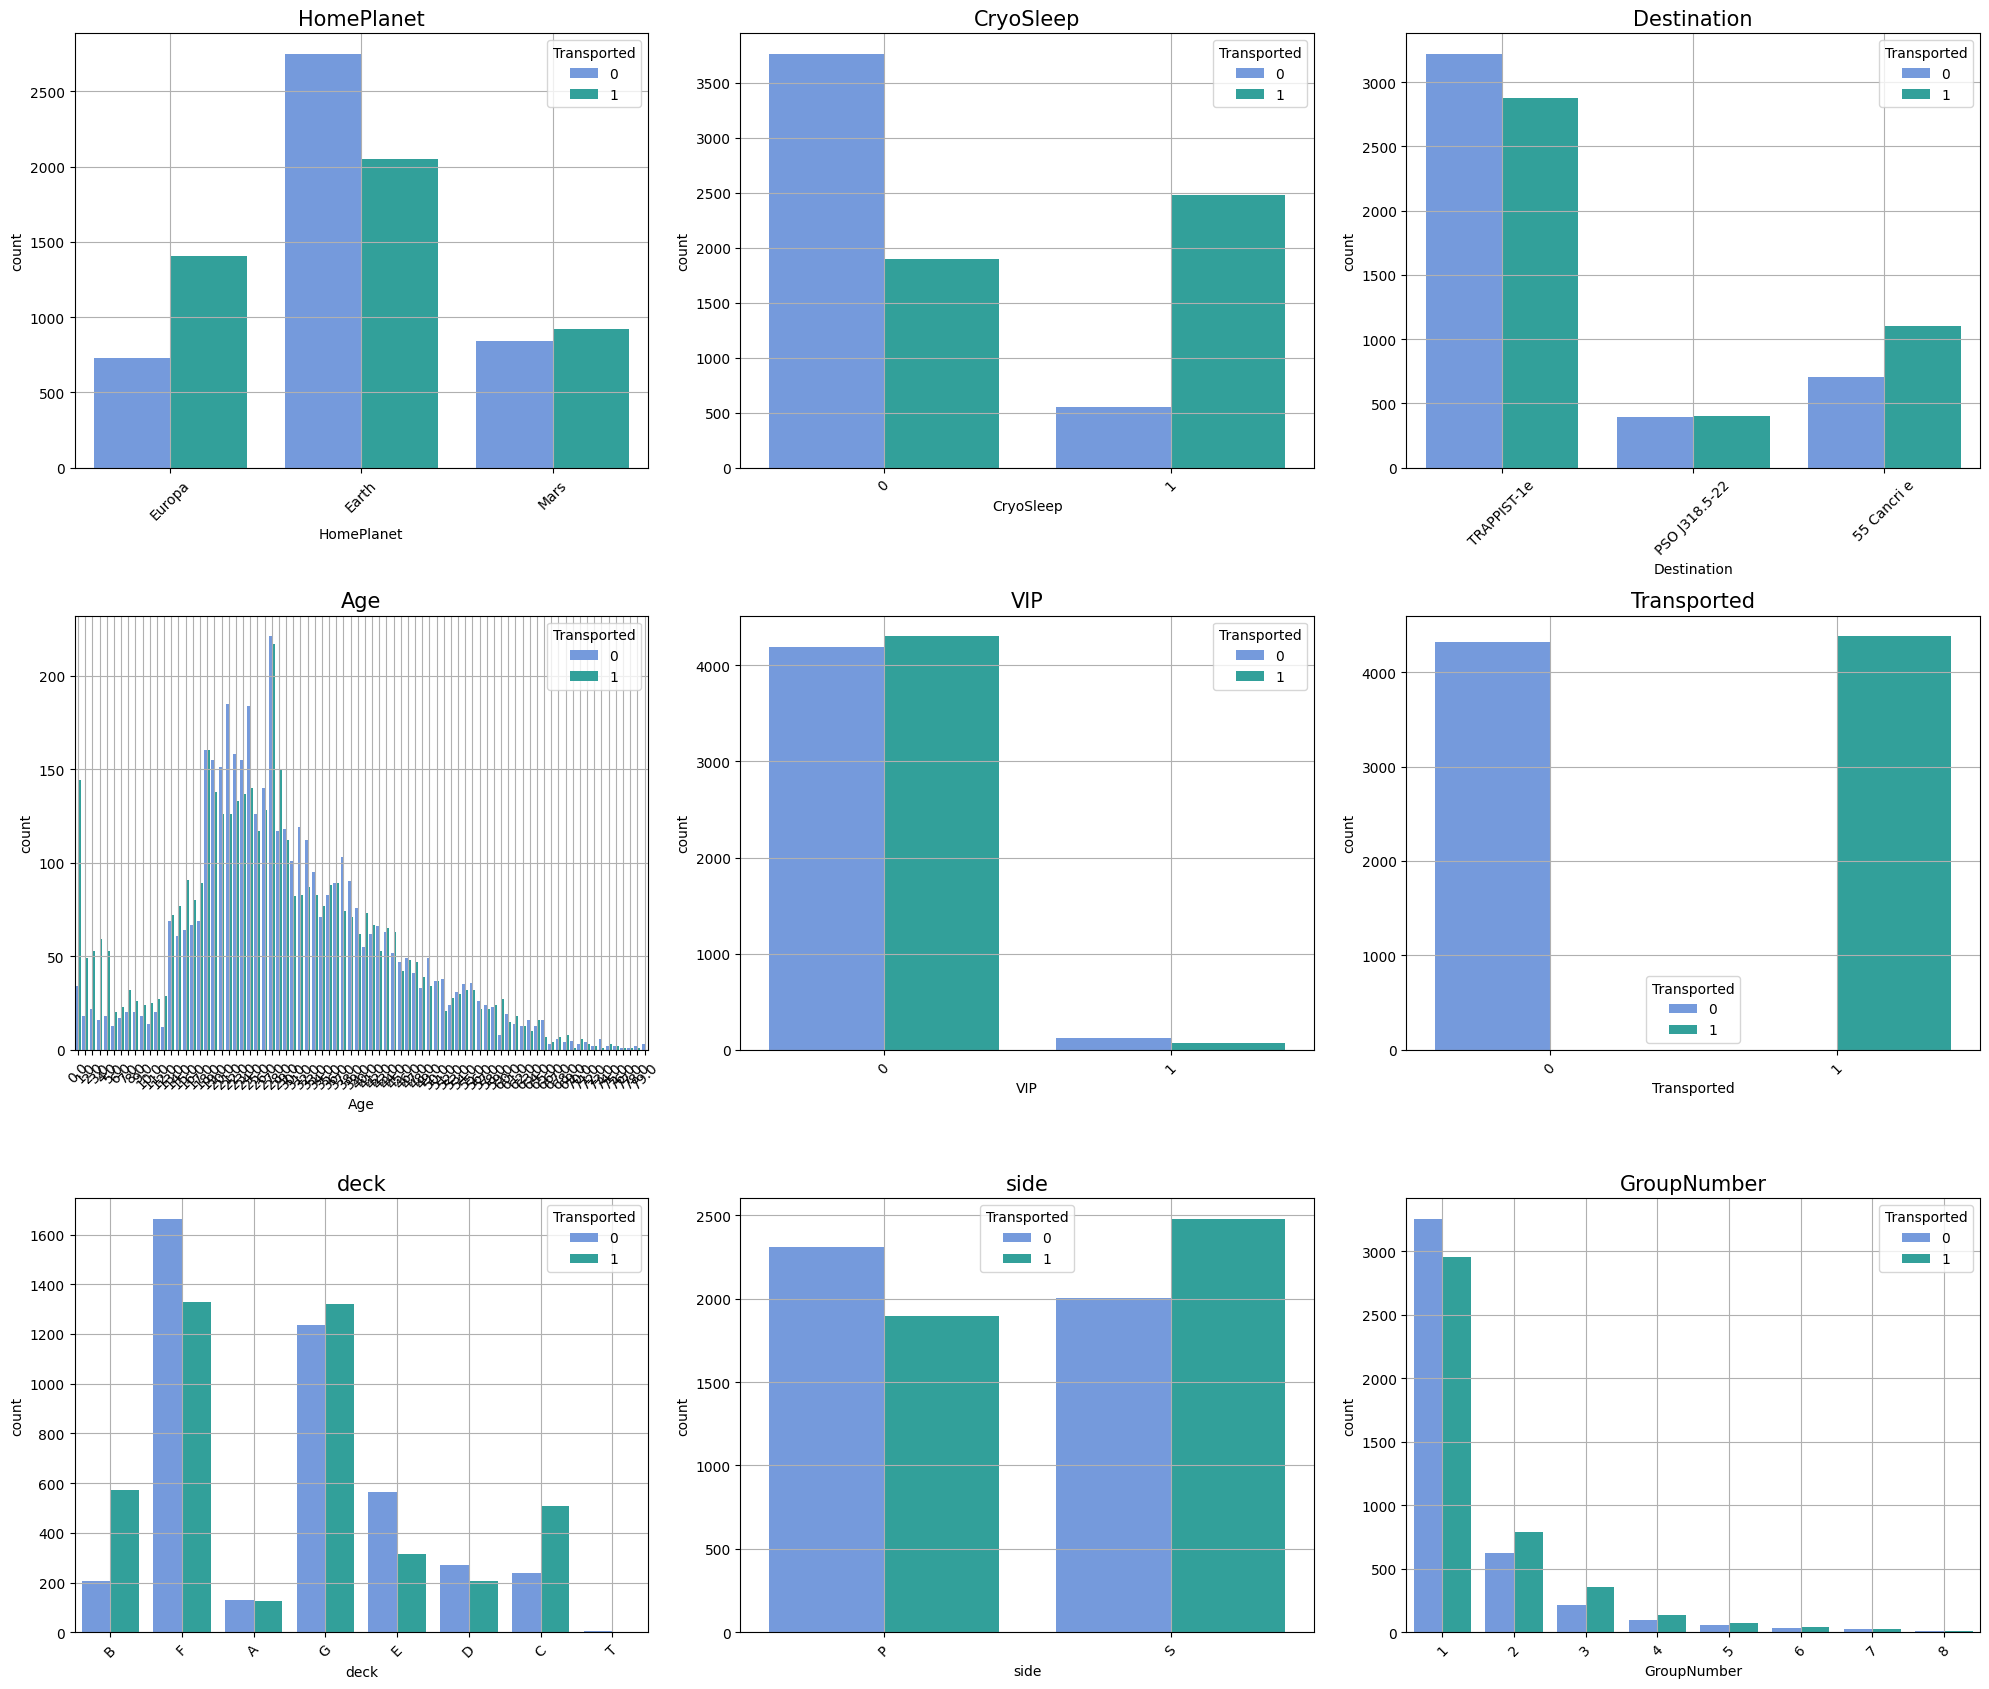

In [12]:
# визуализация зависимостей от целевой переменной
col_list = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
            'Transported', 'deck', 'side', 'GroupNumber']
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 17))
axes = axes.flatten()

for i, col in enumerate(col_list):
    colors = {0: 'cornflowerblue', 1: 'lightseagreen'}
    sns.countplot(data=train, x=col, hue='Transported', palette=colors, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(col, fontsize=15)
    axes[i].grid()

for i in range(len(col_list), nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

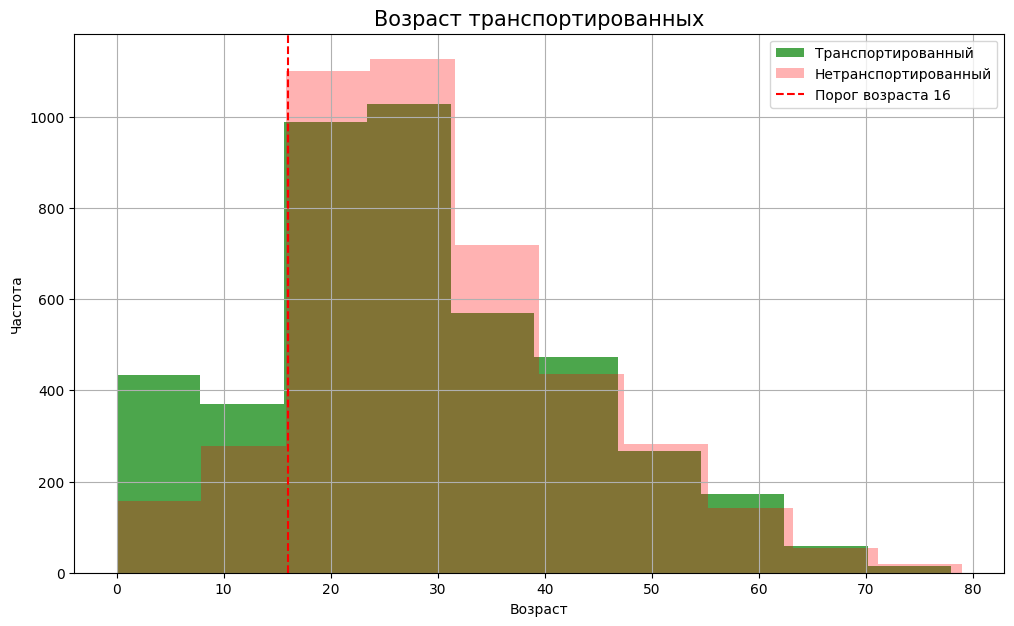

In [13]:
# наглядное распределение возраста
plt.figure(figsize=(12, 7))

plt.hist(train.query('Transported == 1')['Age'], alpha=0.7, label='Транспортированный', color='green')
plt.hist(train.query('Transported == 0')['Age'], alpha=0.3, label='Нетранспортированный', color='red')
plt.axvline(x=16, color='red', linestyle='--', label='Порог возраста 16')
plt.title('Возраст транспортированных', fontsize=15)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

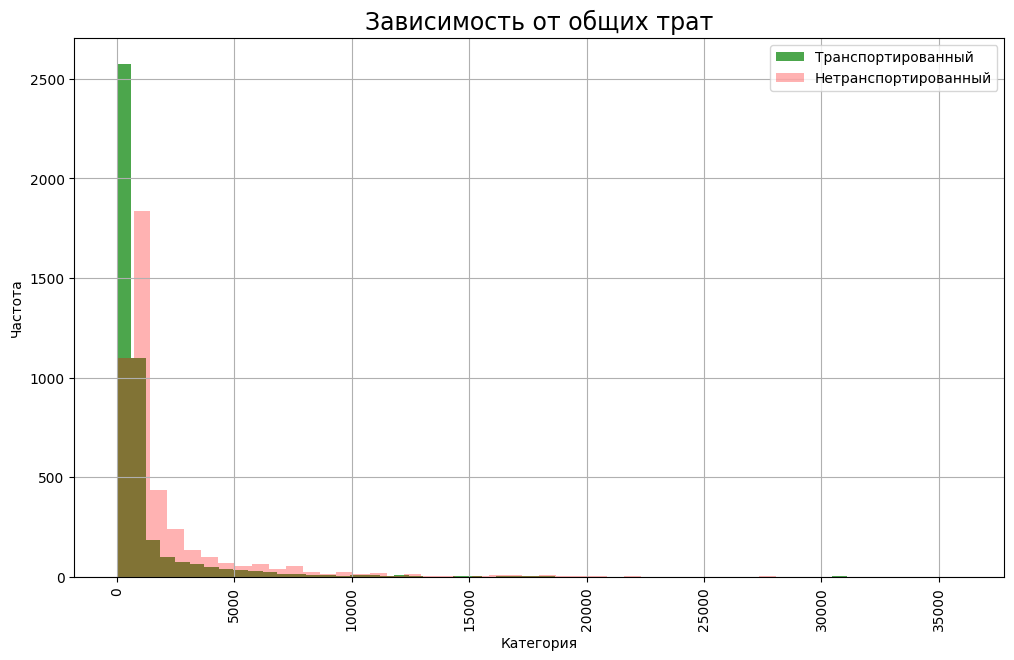

In [14]:
# наглядное распределение трат
plt.figure(figsize=(12, 7))

plt.hist(train.query('Transported == 1')['pay'], alpha=0.7, label='Транспортированный', color='green', bins=50)
plt.hist(train.query('Transported == 0')['pay'], alpha=0.3, label='Нетранспортированный', color='red', bins=50)

plt.title('Зависимость от общих трат', fontsize=17)
plt.xlabel('Категория')
plt.ylabel('Частота')
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.show()

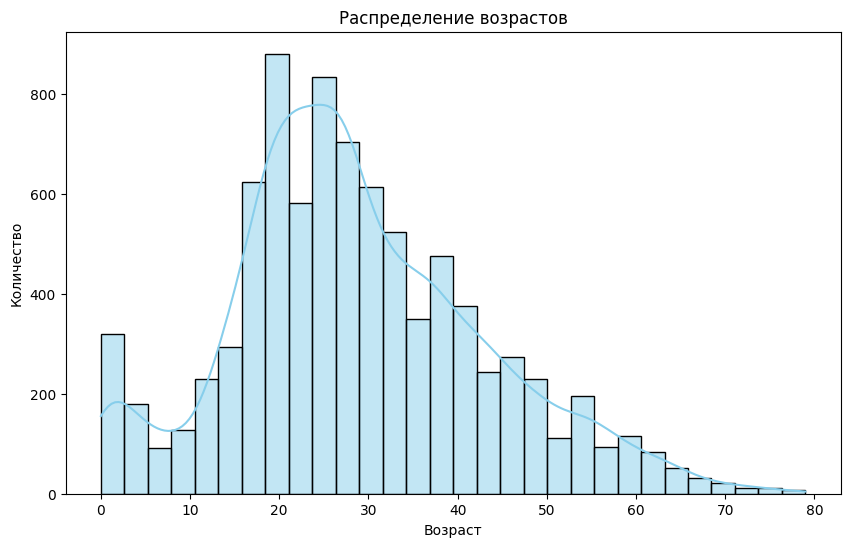

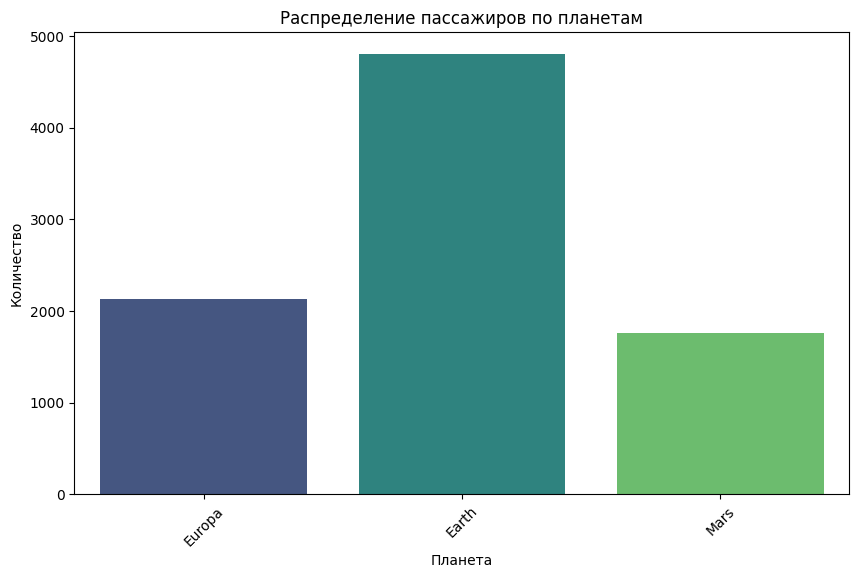

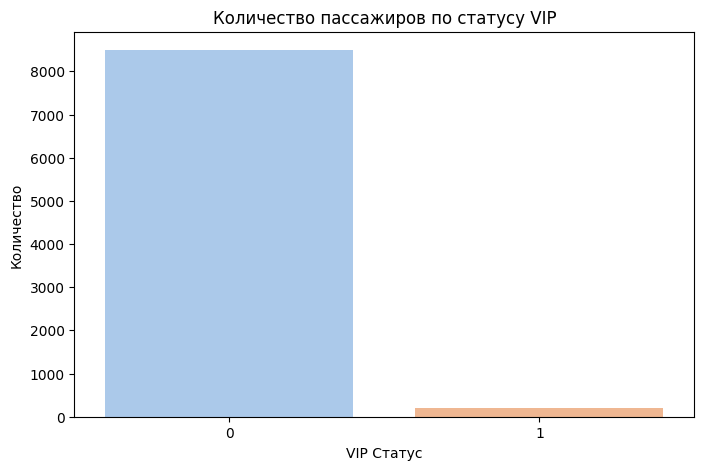

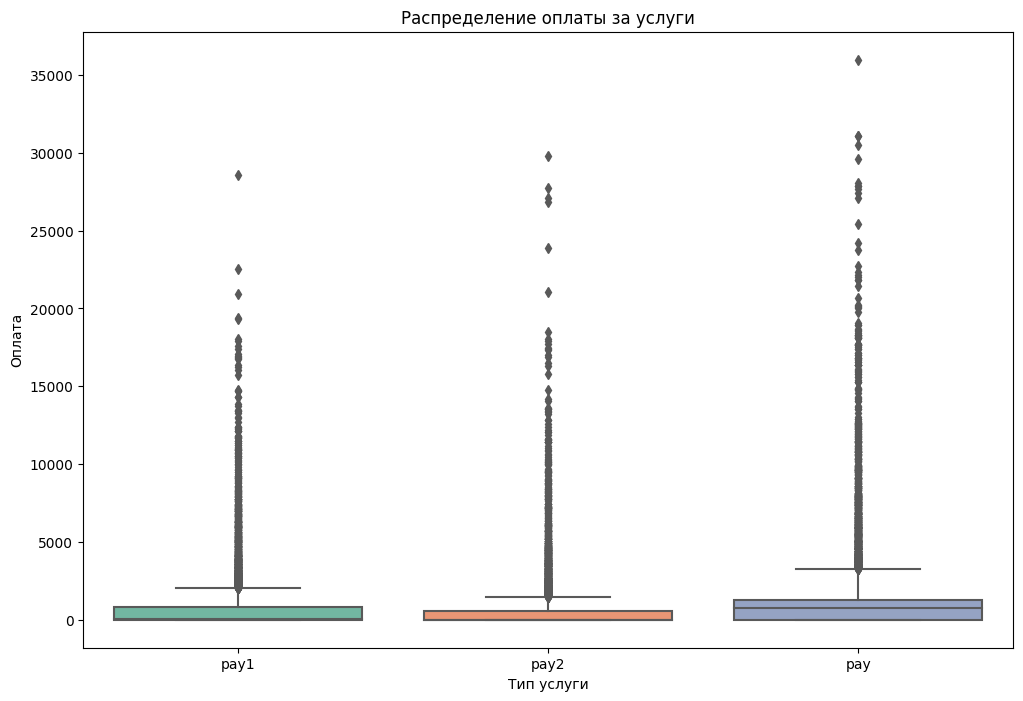

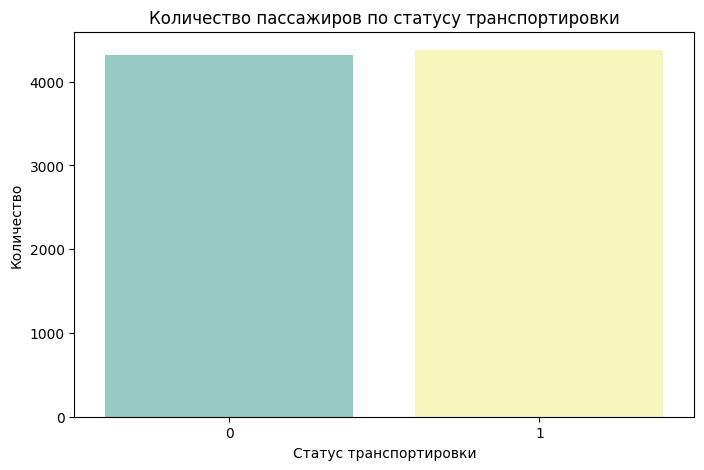

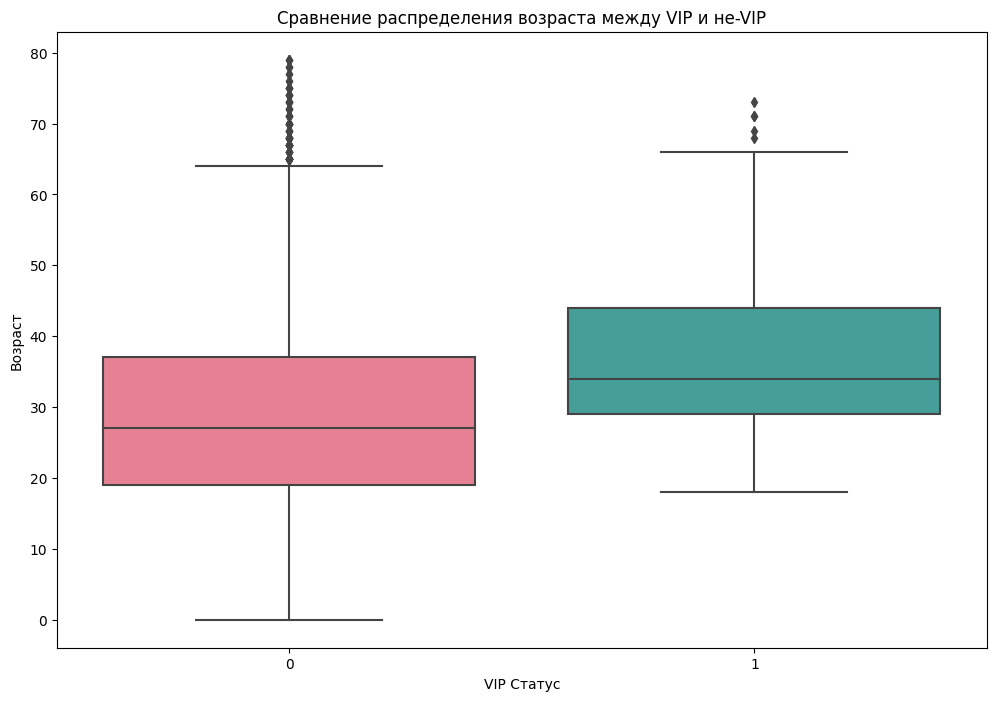

In [15]:
# визуализация распределений пассажиров
plt.rcParams['font.family'] = 'DejaVu Sans'

# распределение возрастов
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], bins=30, kde=True, color='skyblue')
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

# распределение по планетам
plt.figure(figsize=(10, 6))
sns.countplot(x='HomePlanet', data=train, palette='viridis')
plt.title('Распределение пассажиров по планетам')
plt.xlabel('Планета')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

# количество пассажиров в зависимости от VIP-статуса
plt.figure(figsize=(8, 5))
sns.countplot(x='VIP', data=train, palette='pastel')
plt.title('Количество пассажиров по статусу VIP')
plt.xlabel('VIP Статус')
plt.ylabel('Количество')
plt.show()

# распределение оплаты за услуги
plt.figure(figsize=(12, 8))
sns.boxplot(data=train[['pay1', 'pay2', 'pay']], palette='Set2')
plt.title('Распределение оплаты за услуги')
plt.xlabel('Тип услуги')
plt.ylabel('Оплата')
plt.show()

# распределение по типу транспортного средства
plt.figure(figsize=(8, 5))
sns.countplot(x='Transported', data=train, palette='Set3')
plt.title('Количество пассажиров по статусу транспортировки')
plt.xlabel('Статус транспортировки')
plt.ylabel('Количество')
plt.show()

# сравнение распределений VIP и не-VIP
plt.figure(figsize=(12, 8))
sns.boxplot(x='VIP', y='Age', data=train, palette='husl')
plt.title('Сравнение распределения возраста между VIP и не-VIP')
plt.xlabel('VIP Статус')
plt.ylabel('Возраст')
plt.show()

## Selection of hyperparameters with cross-validation

In [16]:
cat_col = train.select_dtypes(include=['object', 'category']).columns.to_list()
train[cat_col] = train[cat_col].astype(str)

X = train.drop(['Transported'], axis=1)
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

train_pool = Pool(X_train, label=y_train, cat_features=cat_col)

model = CatBoostClassifier(random_seed=42,
                           cat_features=cat_col,
                           verbose=0,
                           n_estimators=100)

param_grid = {'depth': list(range(1, 10)),
              'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5, verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Лучшие параметры:', best_params)

model.set_params(depth=best_params['depth'], colsample_bylevel=best_params['colsample_bylevel'])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model)
print(classification_report(y_test, y_pred))
print('Точность МОДЕЛИ', accuracy_score(y_test, y_pred))

Лучшие параметры: {'colsample_bylevel': 0.5, 'depth': 5}
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       874
           1       0.80      0.83      0.81       865

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739

Точность МОДЕЛИ 0.8085106382978723


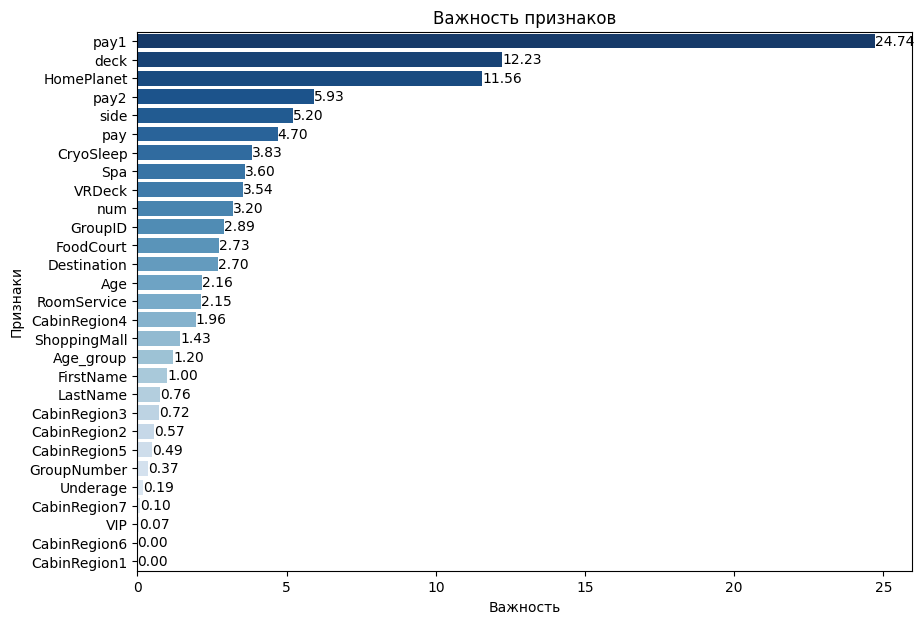

In [17]:
# график важности признаков
feature_importance = model.feature_importances_
feature_names = X_train.columns
sorted_idx = feature_importance.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 7))
barplot = sns.barplot(x=sorted_importance, y=sorted_features, palette='Blues_r')

for index, value in enumerate(sorted_importance):
    barplot.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [18]:
cat_col = train.select_dtypes(include=['object', 'category']).columns.to_list() 
train[cat_col] = train[cat_col].astype(str)
      
X = train.drop(['Transported', 'Underage', 'VIP'], axis=1)
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

model = CatBoostClassifier(random_seed=42,
                           cat_features=cat_col,
                           verbose=100,
                           n_estimators=1000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model)
print(classification_report(y_test, y_pred))
print('Точность МОДЕЛИ', accuracy_score(y_test, y_pred)) 

Learning rate set to 0.023581
0:	learn: 0.6814246	total: 24.5ms	remaining: 24.5s
100:	learn: 0.4135382	total: 2.58s	remaining: 22.9s
200:	learn: 0.3831151	total: 4.97s	remaining: 19.7s
300:	learn: 0.3678027	total: 7.36s	remaining: 17.1s
400:	learn: 0.3551942	total: 9.78s	remaining: 14.6s
500:	learn: 0.3419662	total: 12.3s	remaining: 12.2s
600:	learn: 0.3298923	total: 14.8s	remaining: 9.84s
700:	learn: 0.3191076	total: 17.3s	remaining: 7.37s
800:	learn: 0.3100595	total: 19.8s	remaining: 4.92s
900:	learn: 0.3011175	total: 22.3s	remaining: 2.45s
999:	learn: 0.2929681	total: 24.7s	remaining: 0us
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       874
           1       0.82      0.83      0.82       865

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

Точность МОДЕЛИ 0.8246118458884416


## Analysis of forecasting results and threshold selection

In [19]:
# настройка оптимального порога
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Оптимальный порог: {optimal_threshold}')

Оптимальный порог: 0.5407194453916767


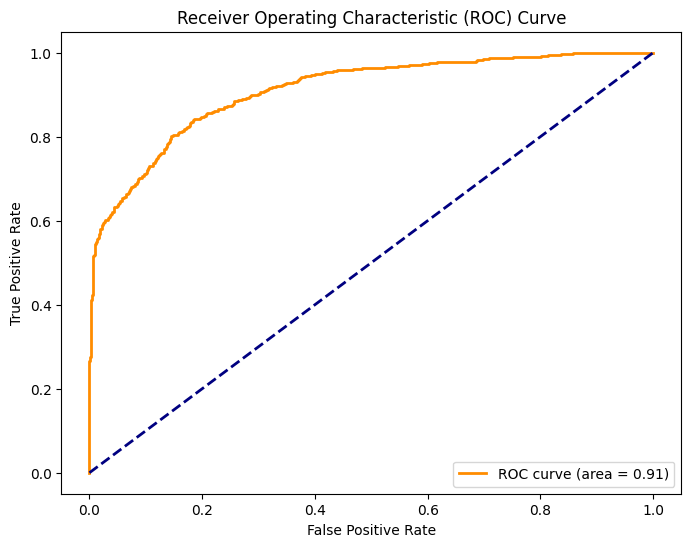

In [20]:
# график ROC-кривой
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

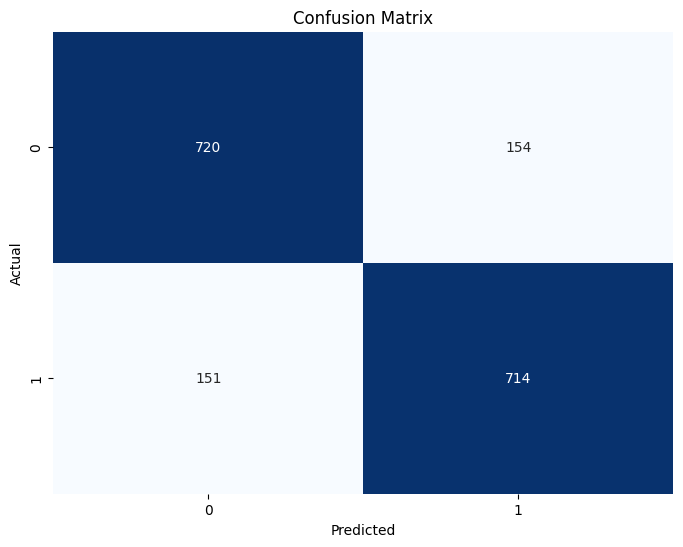

In [21]:
# матрица ошибок
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

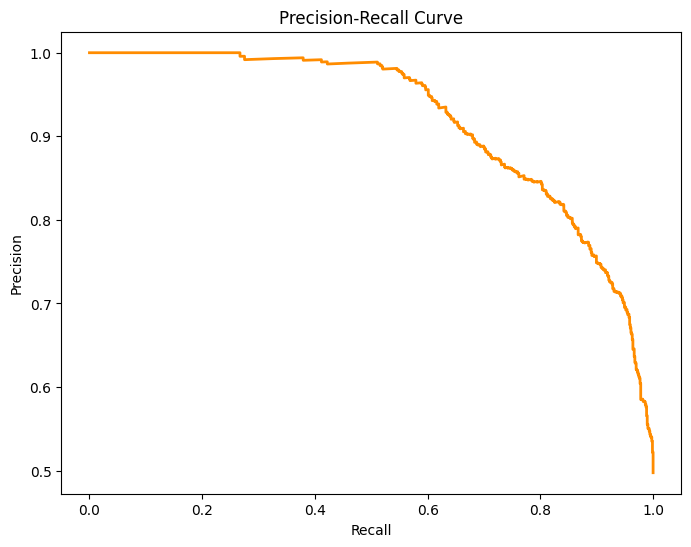

In [22]:
# график зависимости метрик от порога (Precision-Recall Curve)
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

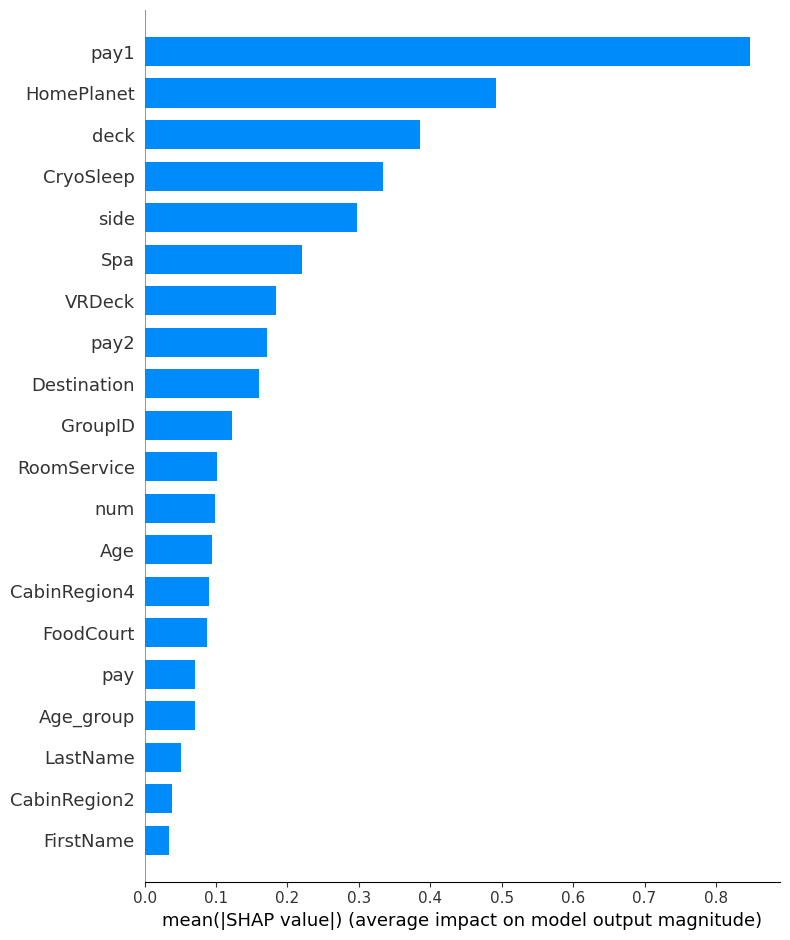

In [23]:
# график подсветки ошибок (SHAP Values):
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)

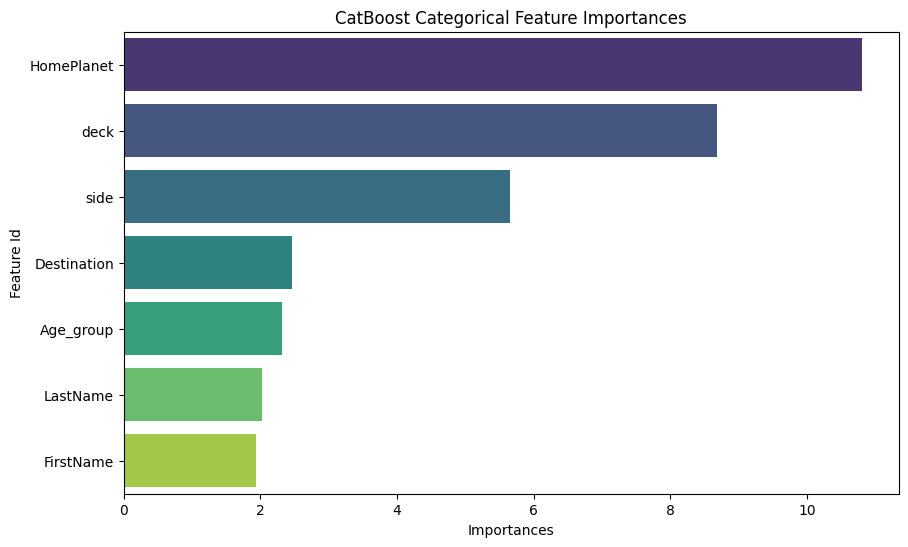

In [24]:
# график важности категориальных признаков
cat_feature_importance = model.get_feature_importance(type='FeatureImportance', prettified=True)
cat_feature_importance = cat_feature_importance[cat_feature_importance['Feature Id'].isin(cat_col)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=cat_feature_importance, palette='viridis')
plt.title('CatBoost Categorical Feature Importances')
plt.show()

## Data preparation and training on a control sample

In [26]:
test = preprocessing(test)
test = preprocess_data(test)
test = cabin_num(test)

In [27]:
cat_col = test.select_dtypes(include=['object', 'category']).columns.to_list()  
test[cat_col] = test[cat_col].astype(str)
     
X_train = train.drop(['Transported', 'Underage', 'VIP'], axis=1)
y_train = train['Transported']
test = test.drop(['Underage', 'VIP'], axis=1)

model = CatBoostClassifier(random_seed=42,
                           cat_features=cat_col,
                           verbose=10,
                           n_estimators=100)

model.fit(X_train, y_train)
y_prob_test = model.predict_proba(test)[:, 1]

threshold = 0.4  
y_pred_test = (y_prob_test > threshold).astype(int)
sample_submission['Transported'] = y_pred_test
sample_submission['Transported'].replace({1: True, 0: False}, inplace=True)
sample_submission.to_csv('submission.csv', index=False)

Learning rate set to 0.214269
0:	learn: 0.6038485	total: 19.9ms	remaining: 1.97s
10:	learn: 0.4113944	total: 263ms	remaining: 2.12s
20:	learn: 0.3826554	total: 493ms	remaining: 1.85s
30:	learn: 0.3696205	total: 714ms	remaining: 1.59s
40:	learn: 0.3590560	total: 930ms	remaining: 1.34s
50:	learn: 0.3487322	total: 1.16s	remaining: 1.11s
60:	learn: 0.3379144	total: 1.39s	remaining: 890ms
70:	learn: 0.3271385	total: 1.61s	remaining: 660ms
80:	learn: 0.3190691	total: 1.84s	remaining: 431ms
90:	learn: 0.3116279	total: 2.05s	remaining: 203ms
99:	learn: 0.3065344	total: 2.25s	remaining: 0us


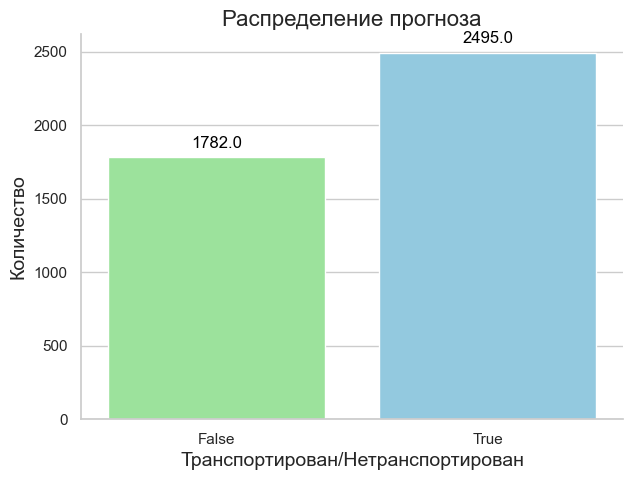

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Transported', data=sample_submission, palette=['lightgreen', 'skyblue'])

plt.title('Распределение прогноза', fontsize=16)
plt.xlabel('Транспортирован/Нетранспортирован', fontsize=14)
plt.ylabel('Количество', fontsize=14)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, color='black')

sns.despine()
plt.show()

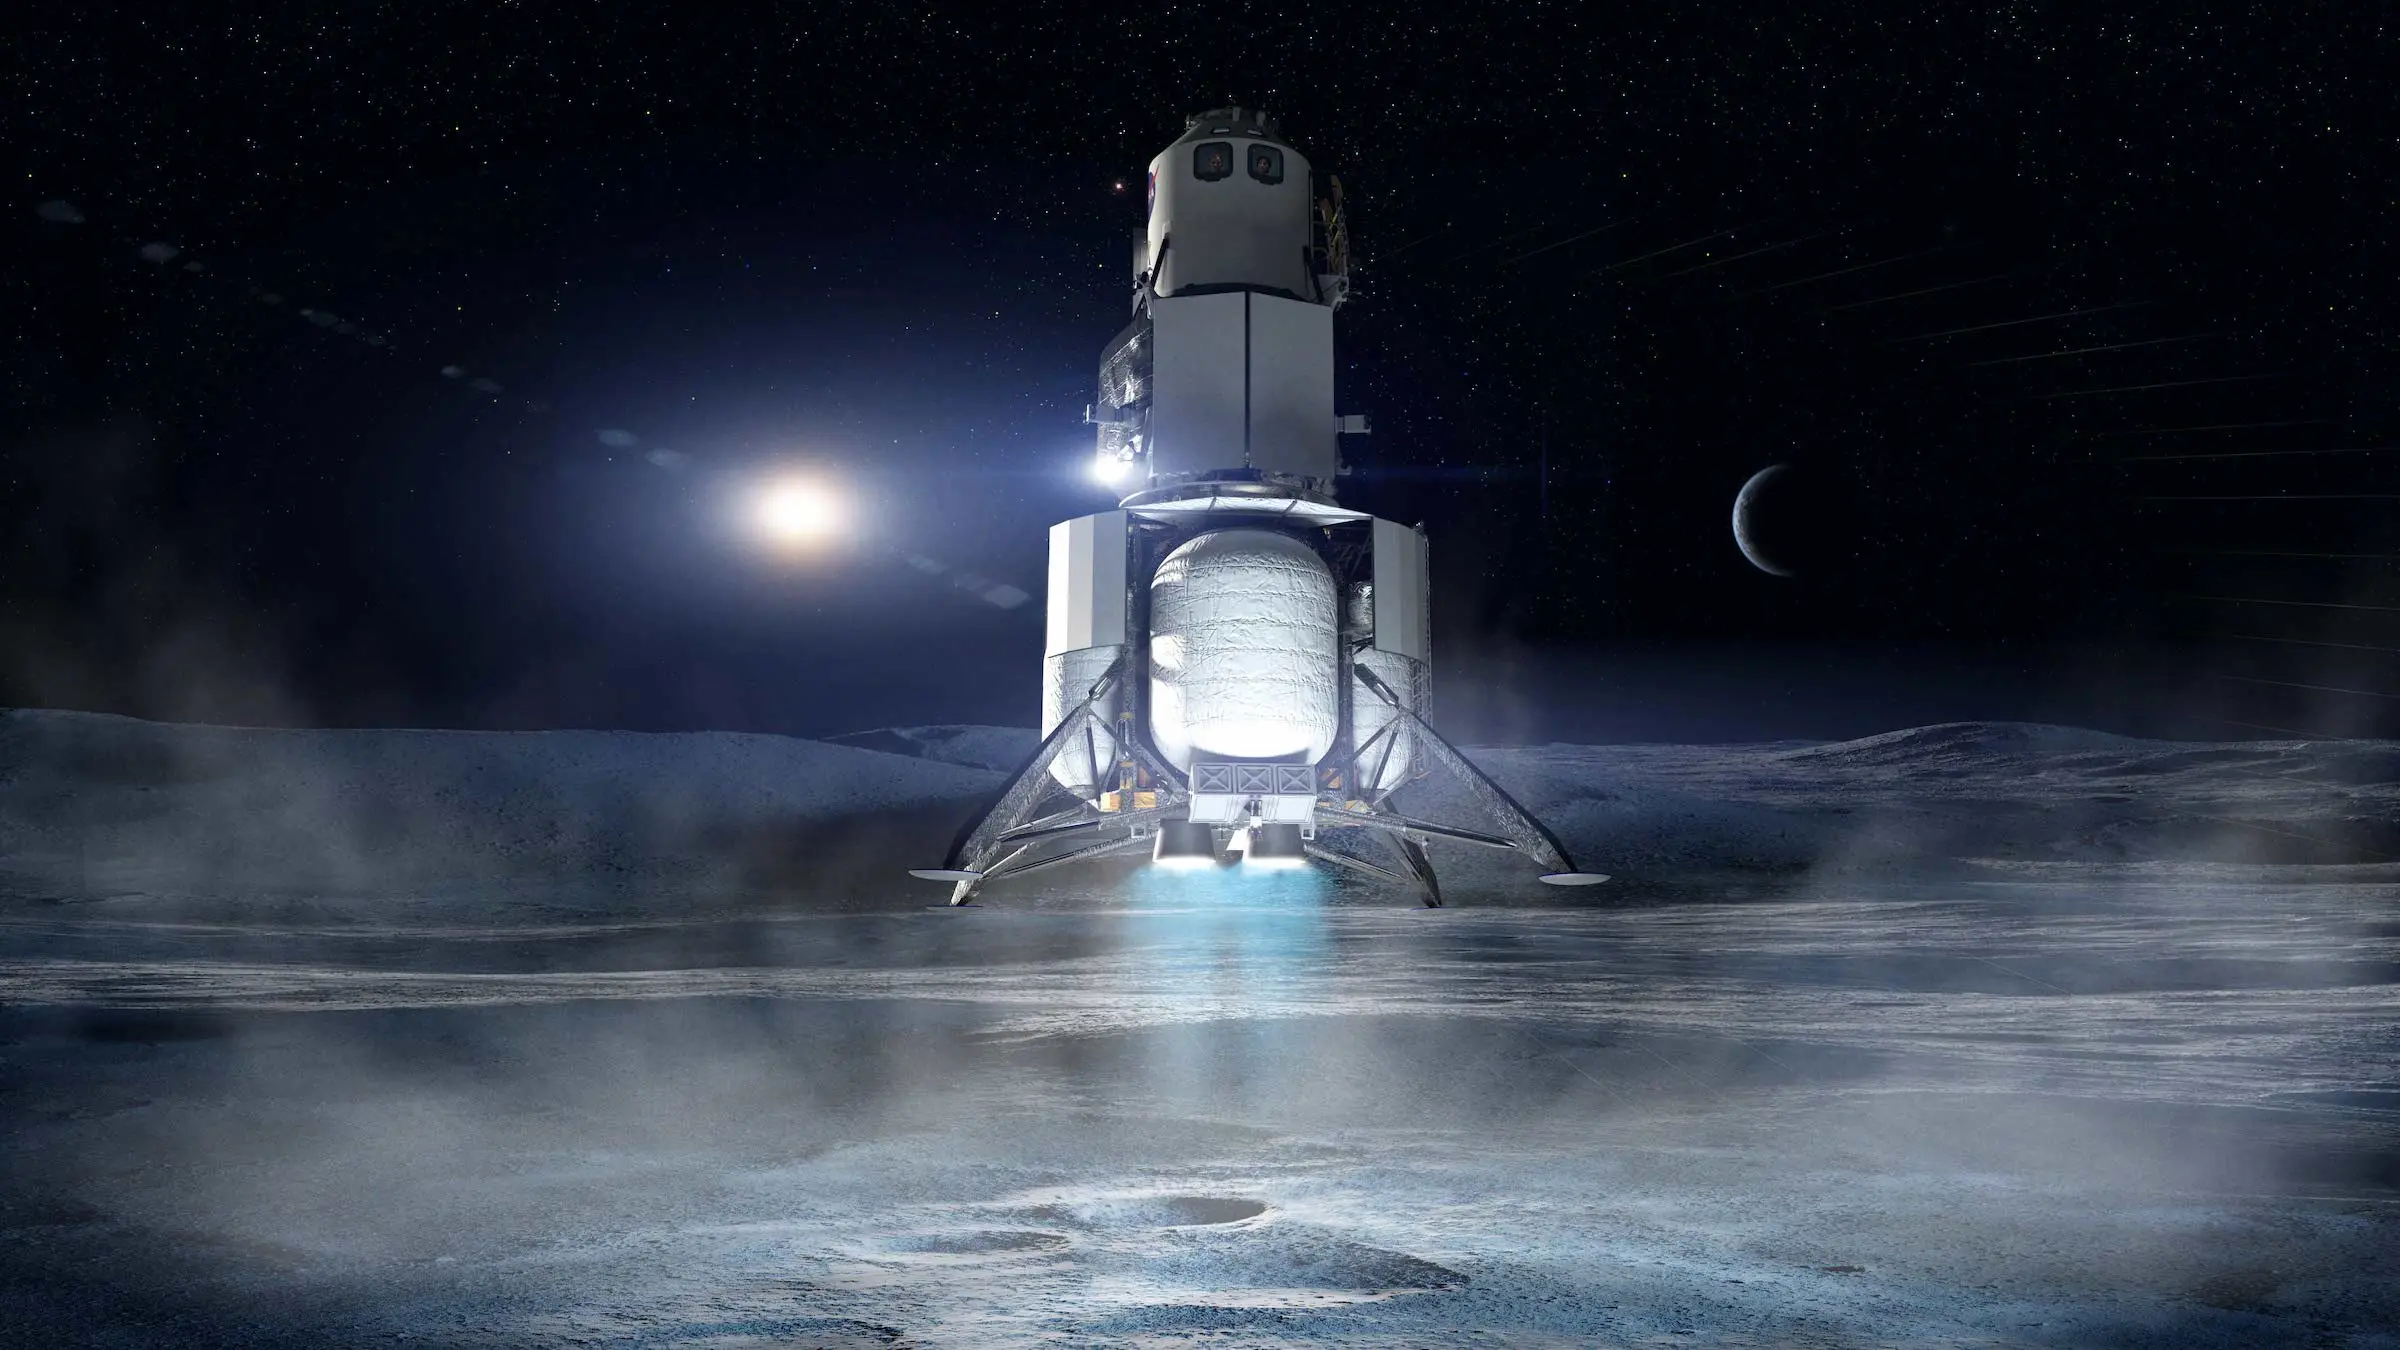

In [30]:
Image(filename="fon_2.jpg", width=1500, height=1200)